### Import the necessary libraries

In [469]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.inspection import permutation_importance

### Read data

In [470]:
df = gpd.read_file('../data/processed/high_res.shp')

### Predict only using population density and HDI

In [471]:
#fit random forest model
X = df[['Pop_den', "HDI", "urbanicity"]]  # Features
feature_names =  X.columns.tolist()
y = df['Cases']

# Stratify based on 'Province'
X_train, X_test, y_train, y_test, train_index, test_index = train_test_split(
    X, y, df.index, test_size=0.3, random_state=38, stratify=df[["Province"]])

# Now you have train_index and test_index containing the original indices
# of the rows that went into training and testing sets respectively.

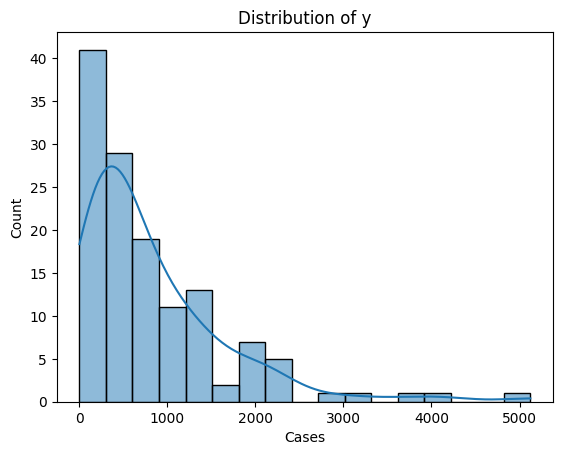

Skewness: 2.2377674169392368


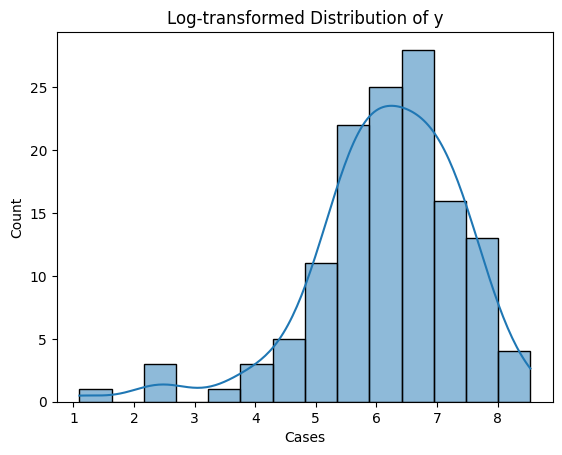

In [472]:
#plot the distribution of y to determine whether i need to log transform it

# Plot the distribution of y
sns.histplot(y, kde=True)
plt.title("Distribution of y")
plt.show()

# Check if the distribution is highly skewed (optional)
skewness = y.skew()
print(f"Skewness: {skewness}")

# If skewed, apply log transformation and plot again
if skewness > 1:  # You can adjust this threshold based on your data
    y_log = np.log1p(y)  # log1p is log(1 + y), handles zeros gracefully
    sns.histplot(y_log, kde=True)
    plt.title("Log-transformed Distribution of y")
    plt.show()


In [473]:
#since log transforming doesnt rly help, can winzorise instead:
# Manual winsorization with pandas
lower = y.quantile(0.05)
upper = y.quantile(0.95)
y_winsorized = y.clip(lower=lower, upper=upper)


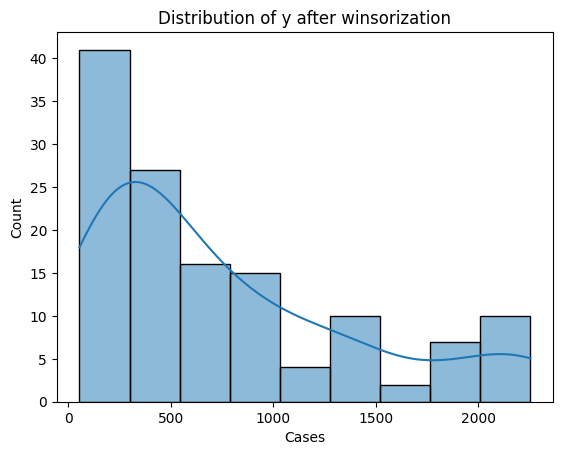

Skewness: 1.0312946432740635


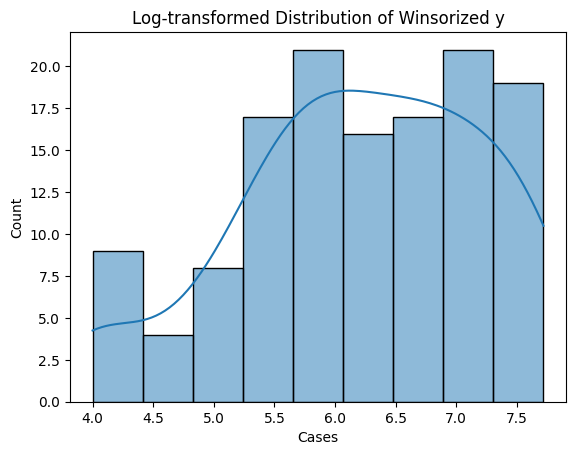

In [474]:
#check plot for y_winsorized
# Plot the distribution of y
sns.histplot(y_winsorized, kde=True)
plt.title("Distribution of y after winsorization")
plt.show()

# Check if the distribution is highly skewed (optional)
skewness = y_winsorized.skew()
print(f"Skewness: {skewness}")

# If skewed, apply log transformation and plot again
if skewness > 1:  # You can adjust this threshold based on your data
    y_log_w = np.log1p(y_winsorized)  # log1p is log(1 + y), handles zeros gracefully
    sns.histplot(y_log_w, kde=True)
    plt.title("Log-transformed Distribution of Winsorized y")
    plt.show()

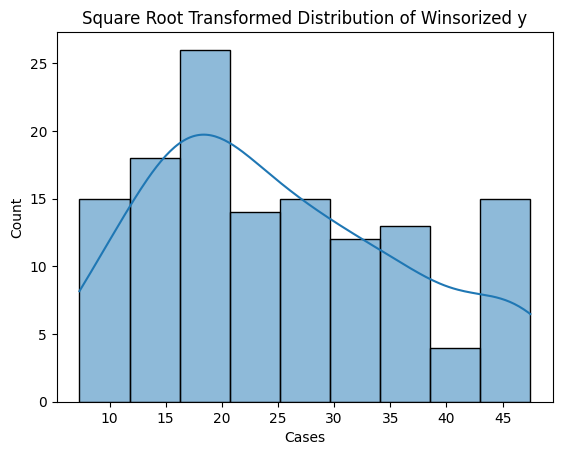

Skewness of sqrt-transformed y: 0.4317123919046788


In [475]:
#how abt square rooting:
y_sqrt = np.sqrt(y_winsorized)  # Square root transformation
sns.histplot(y_sqrt, kde=True)
plt.title("Square Root Transformed Distribution of Winsorized y")
plt.show()
print(f"Skewness of sqrt-transformed y: {y_sqrt.skew()}")


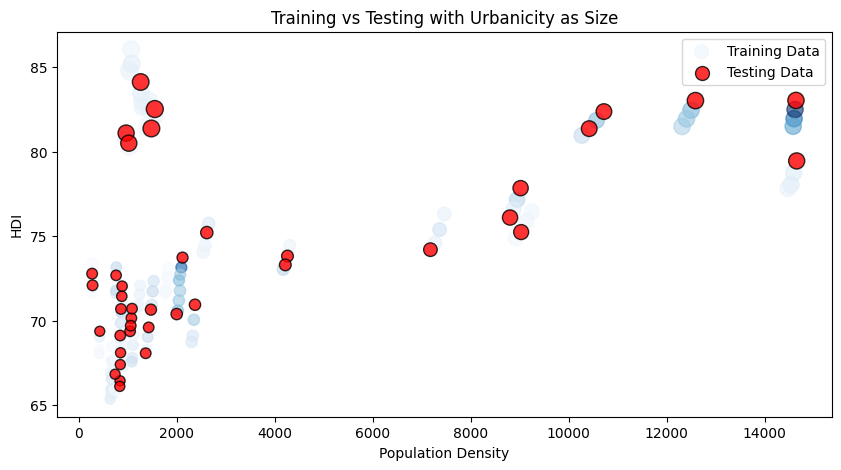

In [476]:
plt.figure(figsize=(10, 5))

# Training data
plt.scatter(X_train['Pop_den'], X_train['HDI'], 
            c=y_train, cmap='Blues', 
            s=50 + 100 * X_train['urbanicity'],  # marker size varies with urbanicity
            alpha=0.6, label='Training Data')

# Testing data
plt.scatter(X_test['Pop_den'], X_test['HDI'], 
            c='red', edgecolors='k', 
            s=50 + 100 * X_test['urbanicity'], 
            alpha=0.8, label='Testing Data')

plt.xlabel('Population Density')
plt.ylabel('HDI')
plt.title('Training vs Testing with Urbanicity as Size')
plt.legend()
plt.show()


In [477]:
# Define your param grid
param_grid = {'n_estimators': [100, 200, 300, 500, 1000]}

# Evaluation function
def evaluate_model(y_true, y_pred, label):
    return {
        'version': label,
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred)
    }

# Grid Search function
def run_grid_search(X, y, cv_folds=10):
    grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid,
                        cv=cv_folds, n_jobs=-1, scoring='neg_root_mean_squared_error')
    grid.fit(X, y)
    return int(grid.best_params_['n_estimators'])

results = []

### 1. Original y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=df[["Province"]], random_state=38)
n_original = run_grid_search(X_train, y_train)
rf = RandomForestRegressor(n_estimators=n_original, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
results.append(evaluate_model(y_test, y_pred, "original"))

### 2. Winsorized y
X_train, X_test, y_train_w, y_test_w = train_test_split(X, y_winsorized, test_size=0.3, stratify=df[["Province"]], random_state=38)
n_winsor = run_grid_search(X_train, y_train_w)
rf_w = RandomForestRegressor(n_estimators=n_winsor, random_state=42)
rf_w.fit(X_train, y_train_w)
y_pred_w = rf_w.predict(X_test)
results.append(evaluate_model(y_test_w, y_pred_w, "winsorized"))

### 3. Log transformed y
X_train, X_test, y_train_l, y_test_l = train_test_split(X, y_log, test_size=0.3, stratify=df[["Province"]], random_state=38)
n_log = run_grid_search(X_train, y_train_l)
rf_l = RandomForestRegressor(n_estimators=n_log, random_state=42)
rf_l.fit(X_train, y_train_l)
y_pred_l = rf_l.predict(X_test)
y_pred_l_inv = np.expm1(y_pred_l)
y_test_l_inv = np.expm1(y_test_l)
results.append(evaluate_model(y_test_l_inv, y_pred_l_inv, "log"))

### 4. Square root transformed y
X_train, X_test_s, y_train_s, y_test_s = train_test_split(X, y_sqrt, test_size=0.3, stratify=df[["Province"]], random_state=38)
n_sqrt = run_grid_search(X_train, y_train_s)
rf_s = RandomForestRegressor(n_estimators=n_sqrt, random_state=42)
rf_s.fit(X_train, y_train_s)
y_pred_s = rf_s.predict(X_test_s)
y_pred_s_inv = y_pred_s ** 2
y_test_s_inv = y_test_s ** 2
results.append(evaluate_model(y_test_s_inv, y_pred_s_inv, "sqrt"))

### 5. Log winsorized y
X_train, X_test, y_train_lw, y_test_lw = train_test_split(X, y_log_w, test_size=0.3, stratify=df[["Province"]], random_state=38)
n_logw = run_grid_search(X_train, y_train_lw)
rf_lw = RandomForestRegressor(n_estimators=n_logw, random_state=42)
rf_lw.fit(X_train, y_train_lw)
y_pred_lw = rf_lw.predict(X_test)
y_pred_lw_inv = np.expm1(y_pred_lw)
y_test_lw_inv = np.expm1(y_test_lw)
results.append(evaluate_model(y_test_lw_inv, y_pred_lw_inv, "log winsorized"))

# Summarize results
results_df = pd.DataFrame(results)
print(results_df.sort_values(by=["RMSE", "R2"], ascending=[True, False]))

          version         MAE        RMSE        R2
3            sqrt  383.561308  497.431156  0.266453
1      winsorized  398.338000  501.259260  0.255119
4  log winsorized  389.817264  516.186583  0.210094
2             log  492.865695  723.467691 -0.228330
0        original  589.666550  900.534398 -0.903169


In [478]:
# Create separate datasets for train - test data
df_pointer = df.copy()
df_pointer["split"] = "train"
df_pointer.loc[test_index, 'split'] = 'test'

# Save shapefiles directly
df_pointer[df_pointer["split"] == "train"].to_file('../data/processed/train.shp')
df_pointer[df_pointer["split"] == "test"].to_file('../data/processed/test.shp')


C:\Users\jessi\AppData\Local\Temp\ipykernel_9508\735667816.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True, color="blue")


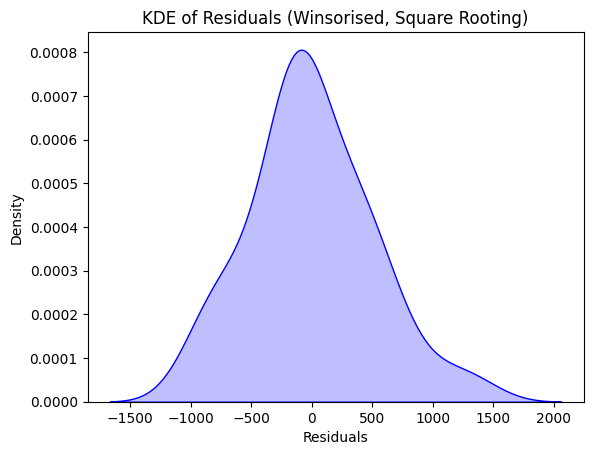

In [479]:
#plot the distribution of errors
# Calculate residuals (difference between observed and predicted values)
residuals = y_test_s_inv - y_pred_s_inv

# Plot KDE of residuals
sns.kdeplot(residuals, shade=True, color="blue")
plt.title('KDE of Residuals (Winsorised, Square Rooting)')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

In [480]:
X_test_s["Predicted_Cases"] = y_pred_s_inv

In [481]:
X_test_s.head()

,Pop_den,HDI,urbanicity,Predicted_Cases
31,857.037088,68.11,0.030005,471.214142
59,9017.451477,77.85,0.701816,1030.812616
10,2615.966462,75.22,0.288146,697.062076
119,865.467937,70.70,0.076849,1019.841541
100,1051.438914,69.38,0.075286,564.255737


In [482]:
len(X_test_s)

40

In [483]:
X_test_s.to_csv("../data/processed/rf_preds.csv")

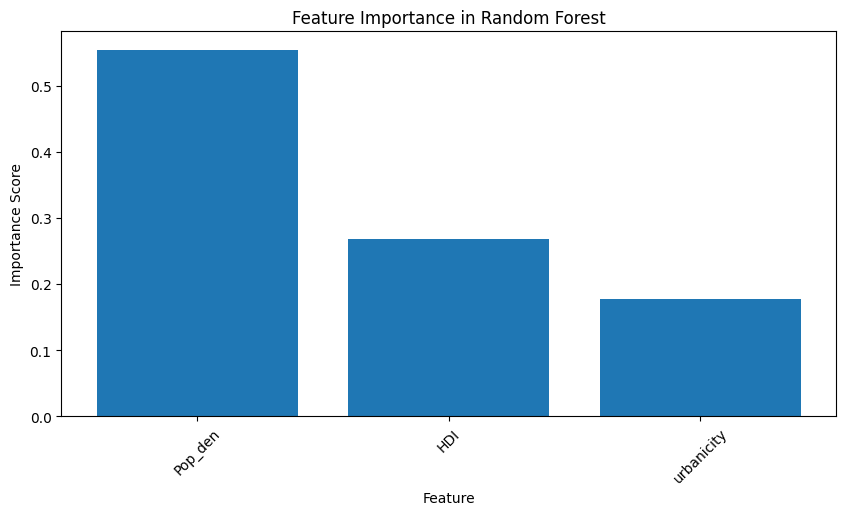

In [484]:
# Get feature importance
importances = rf_s.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort in descending order

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.title("Feature Importance in Random Forest")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

In [485]:
# Save the model
with open("../model_weights/rf/random_forest_model.pkl", "wb") as f:
    pickle.dump(rf, f)

# Load the model
#with open("random_forest_model.pkl", "rb") as f:
#    rf_loaded = pickle.load(f)